# Import

In [9]:
from gsw.conversions import CT_from_pt, SA_from_SP, p_from_z
from gsw.density import sound_speed
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pyinterp
import pyinterp.fill
import pyinterp.backends.xarray
from collections import namedtuple

from datetime import datetime
import cartopy.crs as ccrs

In [27]:
s = xr.open_dataset('/DATASET/eNATL/eNATL60_BLB002_degraded_vosaline.nc') #loading temp data
t = xr.open_dataset('/DATASET/eNATL/eNATL60_BLB002_degraded_votemper.nc') #loading salinity data
c = xr.open_dataset('/DATASET/eNATL/eNATL60_BLB002_sound_speed_0_1000m_regrid.nc') #loading celerity data  
##! Consider the regrid issue, outliers incorporation

In [11]:
s

<xarray.Dataset>
Dimensions:            (y: 308, x: 245, z: 107, time_counter: 365)
Coordinates:
    nav_lon            (y, x) float32 ...
    nav_lat            (y, x) float32 ...
  * z                  (z) float64 0.4805 1.559 2.794 ... 968.4 985.3 1.002e+03
  * time_counter       (time_counter) datetime64[ns] 2009-07-01T12:00:00 ... ...
Dimensions without coordinates: y, x
Data variables:
    degraded_vosaline  (time_counter, z, y, x) float32 ...
Attributes:
    start_date:        -1
    output_frequency:  N/A
    CONFIG:            N/A
    CASE:              N/A
    history:           Partial step computation

In [12]:
t

<xarray.Dataset>
Dimensions:            (y: 308, x: 245, z: 107, time_counter: 365)
Coordinates:
    nav_lon            (y, x) float32 ...
    nav_lat            (y, x) float32 ...
  * z                  (z) float64 0.4805 1.559 2.794 ... 968.4 985.3 1.002e+03
  * time_counter       (time_counter) datetime64[ns] 2009-07-01T12:00:00 ... ...
Dimensions without coordinates: y, x
Data variables:
    degraded_votemper  (time_counter, z, y, x) float32 ...
Attributes:
    start_date:        -1
    output_frequency:  N/A
    CONFIG:            N/A
    CASE:              N/A
    history:           Partial step computation

In [28]:
c

<xarray.Dataset>
Dimensions:   (lon: 240, lat: 240, z: 107, time: 365)
Coordinates:
  * lon       (lon) float64 -65.95 -65.9 -65.85 -65.8 ... -54.1 -54.05 -54.0
  * lat       (lat) float64 32.0 32.05 32.1 32.15 32.2 ... 43.8 43.85 43.9 43.95
  * z         (z) float64 0.4805 1.559 2.794 4.187 ... 968.4 985.3 1.002e+03
  * time      (time) datetime64[ns] 2009-07-01T12:00:00 ... 2010-06-30T12:00:00
Data variables:
    celerity  (time, z, lat, lon) float64 ...

# Maps

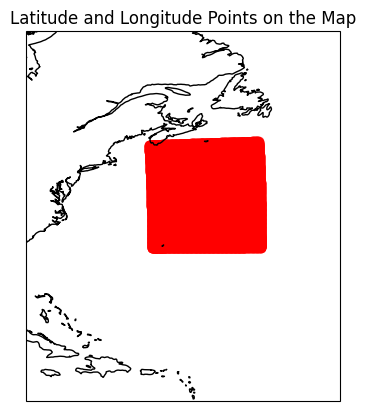

In [13]:
# Create a Cartopy projection (e.g., PlateCarree for lat/lon)
projection = ccrs.PlateCarree()

# Create a map using Cartopy
ax = plt.axes(projection = ccrs.PlateCarree())
#ax.stock_img()  ###view all earth
ax.set_extent([-80, -45, 15, 55])

for i in range(245):
    lat = t.nav_lat.values[:,i]
    lon = t.nav_lon.values[:,i]

    # Plot points on the map
    plt.scatter(lon, lat, color='red', marker='o', transform=projection, alpha= 0.5)

# Add map features (e.g., coastlines, country borders, etc.)
ax.coastlines()

# Set the title
plt.title('Latitude and Longitude Points on the Map')

# Show the plot
plt.show()


#! What is the CRS ?

# Variables

In [14]:
i_time = 0
i_lat = 0
i_lon = 0

## Depth

Text(0.5, 0, 'points')

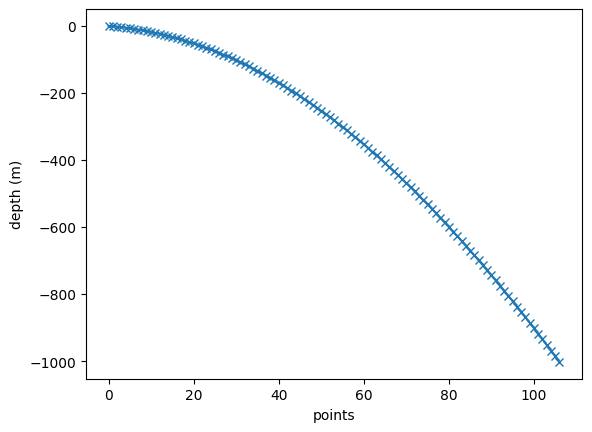

In [15]:
plt.plot(-t.z.values, '-x')  ##t.z is defined postive down, hence the '-'
plt.ylabel("depth (m)")
plt.xlabel("points")

## Practical Salinity

Text(0.5, 1.0, 'Practical salinity per depth at (-65.97, 32.02) for t=2009-07-01T12')

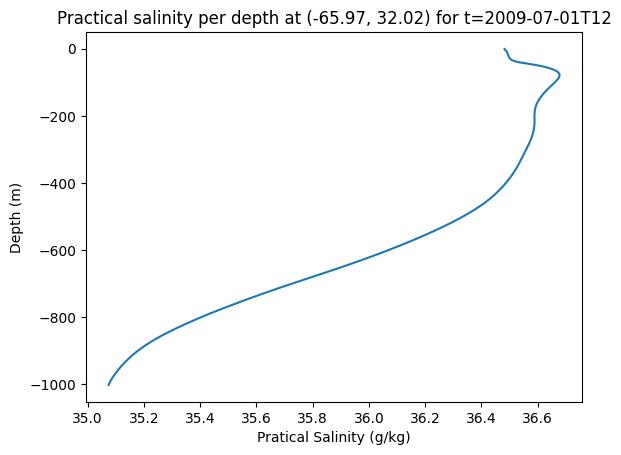

In [16]:
prac_sal = s.degraded_vosaline.values[i_time,:,i_lon,i_lat]

plt.plot(prac_sal,-s.z)
plt.ylabel("Depth (m)")
plt.xlabel("Pratical Salinity (g/kg)")
plt.title(f"Practical salinity per depth at ({s.nav_lon.values[0,i_lat]:.2f}, {s.nav_lat.values[0,i_lat]:.2f}) for t={s.time_counter.values[i_time].astype('datetime64[h]')}")

## Potential Temperature

Text(0.5, 1.0, 'Potential temperature per depth at (-65.97, 32.02) for t=2009-07-01T12')

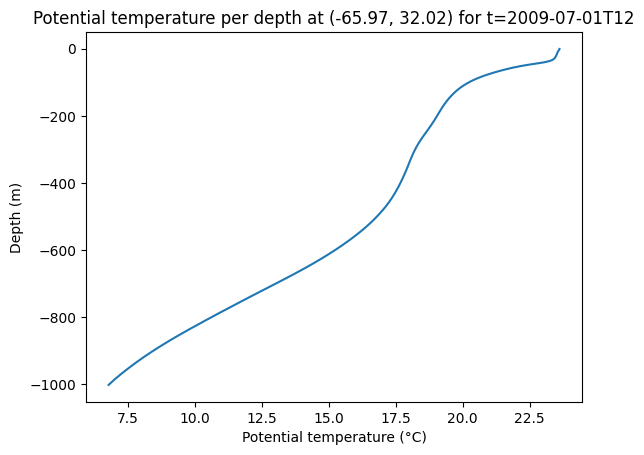

In [17]:
temp = t.degraded_votemper.values[i_time,:,i_lon,i_lat]

plt.plot(temp,-t.z)
plt.ylabel("Depth (m)")
plt.xlabel("Potential temperature (°C)")
plt.title(f"Potential temperature per depth at ({t.nav_lon.values[0,i_lat]:.2f}, {t.nav_lat.values[0,i_lat]:.2f}) for t={t.time_counter.values[i_time].astype('datetime64[h]')}")

## Pressure

Text(0.5, 1.0, 'Pressure per depth at (-65.97, 32.02)')

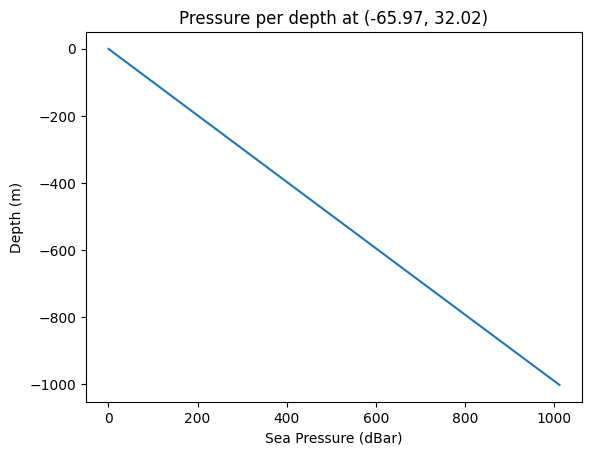

In [18]:
pressure = p_from_z(-t.z, t.nav_lat) # calculating the pressure at vertical levels

plt.plot(pressure.values[:,i_lon,i_lat], -t.z)
plt.ylabel('Depth (m)')
plt.xlabel('Sea Pressure (dBar)')
plt.title(f"Pressure per depth at ({t.nav_lon.values[0,i_lat]:.2f}, {t.nav_lat.values[0,i_lat]:.2f})")
        

## Absolute salinity

In [19]:
SA_array = SA_from_SP(s.degraded_vosaline, pressure, s.nav_lon, s.nav_lat) # calculating absolute salinity from practical salinity

Text(0.5, 1.0, 'Practical salinity per depth at (-65.97, 32.02) for t=2009-07-01T12')

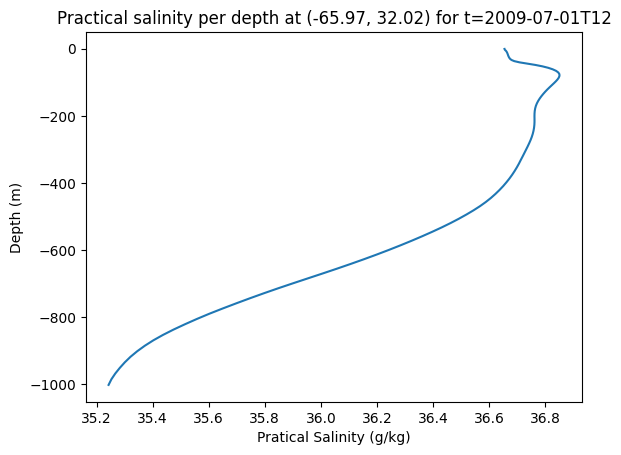

In [20]:
abs_sal = SA_array[i_time,:,i_lat,i_lon]

plt.plot(abs_sal,-s.z)
plt.ylabel("Depth (m)")
plt.xlabel("Pratical Salinity (g/kg)")
plt.title(f"Practical salinity per depth at ({s.nav_lon.values[0,i_lat]:.2f}, {s.nav_lat.values[0,i_lat]:.2f}) for t={s.time_counter.values[i_time].astype('datetime64[h]')}")

## Conservative temperature

In [21]:
CT_array = CT_from_pt(SA_array, t.degraded_votemper) # calculating the conservative temperature from potential temperature

Text(0.5, 1.0, 'Conservative temperature per depth at (-65.97, 32.02) for t=2009-07-01T12')

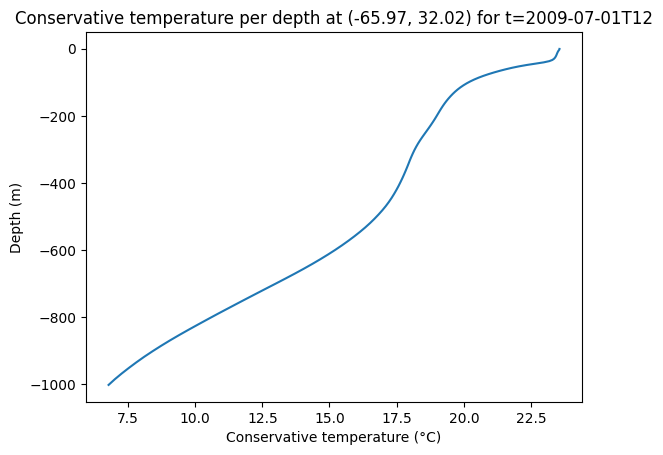

In [22]:
cons_temp = CT_array[i_time,:,i_lat,i_lon]

plt.plot(cons_temp,-t.z)
plt.ylabel("Depth (m)")
plt.xlabel("Conservative temperature (°C)")
plt.title(f"Conservative temperature per depth at ({s.nav_lon.values[0,i_lat]:.2f}, {s.nav_lat.values[0,i_lat]:.2f}) for t={s.time_counter.values[i_time].astype('datetime64[h]')}")

## Sound speed

In [23]:
sound_speed_array = sound_speed(SA_array, CT_array, pressure) # calculating the celerity

In [24]:
ds_sound_speed_array = sound_speed_array.to_dataset(name="celerity")

Text(0.5, 1.0, 'Sound Speed per depth at (-65.97, 32.02) for t=2009-07-01T12')

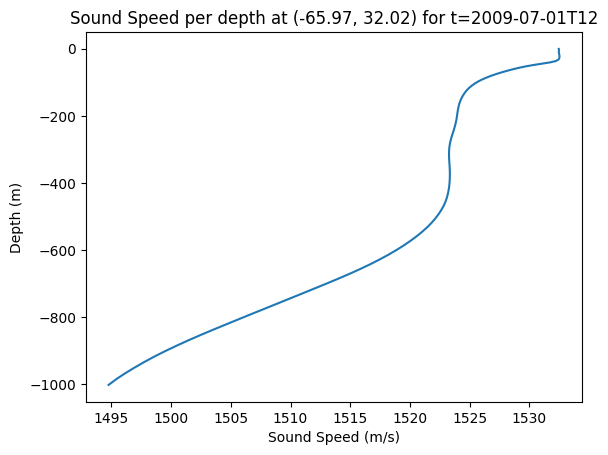

In [25]:
ss = sound_speed_array[i_time,:,i_lat,i_lon]

plt.plot(ss,-t.z)
plt.ylabel("Depth (m)")
plt.xlabel("Sound Speed (m/s)")
plt.title(f"Sound Speed per depth at ({s.nav_lon.values[0,i_lat]:.2f}, {s.nav_lat.values[0,i_lat]:.2f}) for t={s.time_counter.values[i_time].astype('datetime64[h]')}")